In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
#%cd /content/gdrive/MyDrive/
#!ls
#!git clone https://github.com/JonasGeiping/invertinggradients.git
%cd /content/gdrive/MyDrive/Henger/RLdefendFL/new_experiments/
!ls

Mounted at /content/gdrive/
/content/gdrive/MyDrive/Henger/RLdefendFL/new_experiments
 BFL
'Cifar10_mean(500-1000)_res.gsheet'
 data
 IPM
 IPM2_Clip10_Mean0.5_lr0.05_1000epoch_cifar10_resnet18_100c_15a.txt
 IPM+BFL
 MNISTClassifier_init
 NA
 NA_frac1_Clip10_Mean0.5_lr0.05_1000epoch_cifar10_resnet18_100c_15a.txt
 ResNet18_0


In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
from math import floor
from collections import defaultdict
import random
import cv2
from functools import reduce

import math
import copy

import torchvision
from PIL import Image

import os
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, TensorDataset
from collections import OrderedDict
import more_itertools as mit


def get_datasets(data):
    """ returns train and test datasets """
    train_dataset, test_dataset = None, None
    data_dir = '../data'

    if data == 'fmnist':
        transform =  transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.2860], std=[0.3530])])
        train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(data_dir, train=False, download=True, transform=transform)

    elif data == 'mnist':
        apply_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=apply_transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=apply_transform)

    elif data == 'cifar10':
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ])
        train_dataset = datasets.CIFAR10(data_dir, train=True, download=True, transform=transform_train)
        test_dataset = datasets.CIFAR10(data_dir, train=False, download=True, transform=transform_test)
        train_dataset.targets, test_dataset.targets = torch.LongTensor(train_dataset.targets), torch.LongTensor(test_dataset.targets)

    return train_dataset, test_dataset


def add_pattern_bd(x, dataset='cifar10', pattern_type='square', agent_idx=-1):
    """
    adds a trojan pattern to the image
    """
    x = np.array(x.squeeze())

    # if cifar is selected, we're doing a distributed backdoor attack (i.e., portions of trojan pattern is split between agents, only works for plus)
    if dataset == 'cifar10':
        if pattern_type == 'plus':
            start_idx = 5
            size = 6
            if agent_idx == -1:
                # vertical line
                for d in range(0, 3):
                    for i in range(start_idx, start_idx+size+1):
                        x[i, start_idx][d] = 0
                # horizontal line
                for d in range(0, 3):
                    for i in range(start_idx-size//2, start_idx+size//2 + 1):
                        x[start_idx+size//2, i][d] = 0
            else:# DBA attack
                #upper part of vertical
                if agent_idx % 4 == 0:
                    for d in range(0, 3):
                        for i in range(start_idx, start_idx+(size//2)+1):
                            x[i, start_idx][d] = 0

                #lower part of vertical
                elif agent_idx % 4 == 1:
                    for d in range(0, 3):
                        for i in range(start_idx+(size//2)+1, start_idx+size+1):
                            x[i, start_idx][d] = 0

                #left-part of horizontal
                elif agent_idx % 4 == 2:
                    for d in range(0, 3):
                        for i in range(start_idx-size//2, start_idx+size//4 + 1):
                            x[start_idx+size//2, i][d] = 0

                #right-part of horizontal
                elif agent_idx % 4 == 3:
                    for d in range(0, 3):
                        for i in range(start_idx-size//4+1, start_idx+size//2 + 1):
                            x[start_idx+size//2, i][d] = 0

        # elif pattern_type == 'none': return x

    elif dataset == 'mnist':
        if pattern_type == 'square':
            for i in range(5, 7):
                for j in range(6, 11):
                    x[i, j] = 255

    elif dataset == 'fmnist':
        if pattern_type == 'square':
            for i in range(21, 26):
                for j in range(21, 26):
                    x[i, j] = 255

        elif pattern_type == 'plus':
            start_idx = 5
            size = 2
            if agent_idx == -1:
                # vertical line
                for i in range(start_idx, start_idx+size+1):
                    x[i, start_idx] = 255

                # horizontal line
                for i in range(start_idx-size//2, start_idx+size//2 + 1):
                    x[start_idx+size//2, i] = 255
            else:# DBA attack
                #upper part of vertical
                if agent_idx % 4 == 0:
                    for i in range(start_idx, start_idx+(size//2)+1):
                        x[i, start_idx] = 255

                #lower part of vertical
                elif agent_idx % 4 == 1:
                    for i in range(start_idx+(size//2), start_idx+size+1):
                        x[i, start_idx] = 255

                #left-part of horizontal
                elif agent_idx % 4 == 2:
                    for i in range(start_idx-size//2, start_idx+size//4+1):
                        x[start_idx+size//2, i] = 255

                #right-part of horizontal
                elif agent_idx % 4 == 3:
                    for i in range(start_idx-size//4, start_idx+size//2+1):
                        x[start_idx+size//2, i] = 255


    return x

def poison_dataset(dataset, data, base_class, target_class, poison_frac, pattern_type, data_idxs=None, poison_all=False, agent_idx=-1):
    all_idxs = (dataset.targets == base_class).nonzero().flatten().tolist()
    if data_idxs != None:
        all_idxs = list(set(all_idxs).intersection(data_idxs))

    poison_frac = 1 if poison_all else poison_frac
    poison_idxs = random.sample(all_idxs, floor(poison_frac*len(all_idxs)))
    for idx in poison_idxs:
        #if args.data == 'fedemnist':
            #clean_img = dataset.inputs[idx]
        #else:
        clean_img = dataset.data[idx]
        bd_img = add_pattern_bd(clean_img, data, pattern_type=pattern_type, agent_idx=agent_idx)
        #if args.data == 'fedemnist':
             #dataset.inputs[idx] = torch.tensor(bd_img)
        #else:
        dataset.data[idx] = torch.tensor(bd_img)
        dataset.targets[idx] = target_class
    return



In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DatasetSplit(Dataset):
    """ An abstract Dataset class wrapped around Pytorch Dataset class """
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = idxs
        self.targets = torch.Tensor([self.dataset.targets[idx] for idx in idxs])

    def classes(self):
        return torch.unique(self.targets)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        inp, target = self.dataset[self.idxs[item]]
        return inp, target


#def get_parameters(net):
    #for _, val in net.state_dict().items():
        #if np.isnan(val.cpu().numpy()).any(): print(val)
    #return [val.cpu().numpy() for _, val in net.state_dict().items()]

def get_parameters(net):
    #for _, val in net.state_dict().items():
        #if np.isnan(val.cpu().numpy()).any(): print(val)
    result = []
    for _, val in net.state_dict().items():
        #print((len(val.cpu().numpy().shape)))
        if len(val.cpu().numpy().shape)!=0:
            result.append(val.cpu().numpy())
        else:
            result.append(np.asarray([val.cpu().numpy()]))
    #return [val.cpu().numpy() for _, val in net.state_dict().items()]
    return result

def set_parameters(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def train(net, train_iter, epochs, lr):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)

    for _ in range(epochs):
        #for images, labels in trainloader:
        try:
            images, labels = next(train_iter)
        except:
            train_iter.seek(0)
            images, labels = next(train_iter)
        #print(labels)
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(net(images), labels)
        loss.backward()
        optimizer.step()

def test(net, valloader):
    """Validate the network on the 10% training set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for data in valloader:
        #data=next(iter(valloader))
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
    return loss, accuracy



Files already downloaded and verified
Files already downloaded and verified
(32, 32, 3)


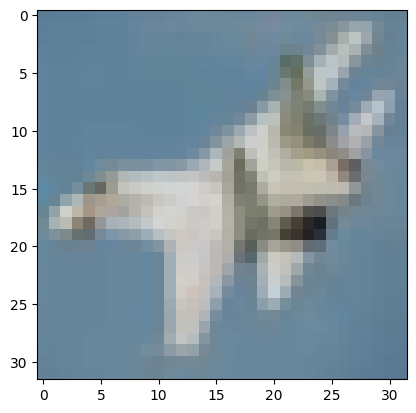

In [ ]:
train_dataset, test_dataset = get_datasets('cifar10')

from PIL import Image
import matplotlib.pyplot as plt

clean_img = test_dataset.data[10]
print(clean_img.shape)
plt.imshow(clean_img)

#poison_img=add_pattern_bd(clean_img, dataset='fmnist', pattern_type='square', agent_idx=-1)
#plt.imshow(poison_img)

#poison_img=add_pattern_bd(clean_img, dataset='fmnist', pattern_type='square', agent_idx=-1)
#plt.imshow(poison_img)



#train_dataset, test_dataset = get_datasets('cifar10')

#clean_img = test_dataset.data[10]
#print(clean_img.shape)
#plt.imshow(clean_img)



#poison_img=add_pattern_bd(clean_img, dataset='cifar10', pattern_type='plus', agent_idx=1)
#plt.imshow(poison_img)
#poison_img=add_pattern_bd(clean_img, dataset='cifar10', pattern_type='plus', agent_idx=2)
#plt.imshow(poison_img)
#poison_img=add_pattern_bd(clean_img, dataset='cifar10', pattern_type='plus', agent_idx=3)
#plt.imshow(poison_img)
#poison_img=add_pattern_bd(clean_img, dataset='cifar10', pattern_type='plus', agent_idx=4)
#plt.imshow(poison_img)

#poison_img=add_pattern_bd(clean_img, dataset='cifar10', pattern_type='plus', agent_idx=-1)
#plt.imshow(poison_img)


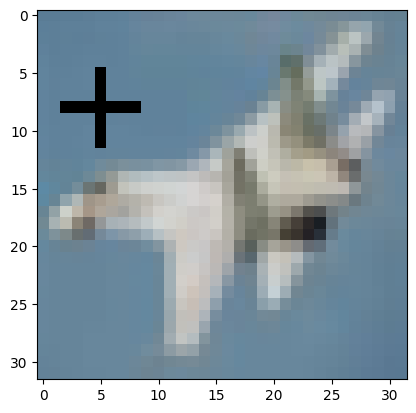

In [ ]:
poison_img=add_pattern_bd(clean_img, dataset='cifar10', pattern_type='plus', agent_idx=-1)
plt.imshow(poison_img)

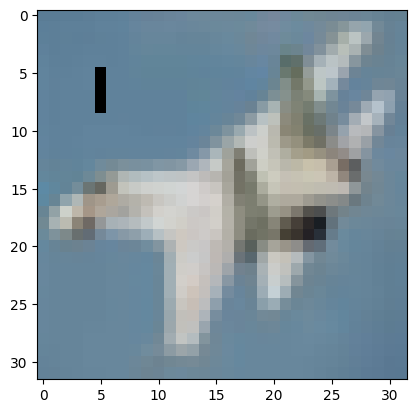

In [ ]:
poison_img=add_pattern_bd(clean_img, dataset='cifar10', pattern_type='plus', agent_idx=0)
plt.imshow(poison_img)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        #print(out.size())
        out = self.layer1(out)
        #print(out.size())
        #out = torch.clamp(out, max=3)
        out = self.layer2(out)
        #print(out.size())
        #out = torch.clamp(out, max=3)
        out = self.layer3(out)
        #out = torch.clamp(out, max=3)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)

        out = out.view(out.size(0), -1)
        #out = torch.clamp(out, max=1.3)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [ ]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.dropout1 = nn.Dropout()
        self.dropout2 = nn.Dropout()
        self.linear1 = nn.Linear(512, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, 10)
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = F.relu(self.linear1(x))
        x = torch.clamp(x, max=0.2)
        x = self.dropout2(x)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [ ]:
def relu(x): return max(0.0, x)

def cos_sim(a, b):
    """Takes 2 vectors a, b and returns the cosine similarity."""

    dot_product = np.dot(a, b) # x.y
    norm_a = np.linalg.norm(a) #|x|
    norm_b = np.linalg.norm(b) #|y|
    return dot_product / (norm_a * norm_b)

def weights_to_vector(weights):
    """Convert NumPy weights to 1-D Numpy array."""
    Lis=[np.ndarray.flatten(ndarray) for ndarray in weights]
    return np.concatenate(Lis, axis=0)

def vector_to_weights(vector,weights):
    """Convert 1-D Numpy array tp NumPy weights."""
    indies = np.cumsum([0]+[layer.size for layer in weights]) #indies for each layer of a weight
    Lis=[vector[indies[i]:indies[i+1]].reshape(weights[i].shape) for i in range(len(weights))]
    return Lis

def common(a,b):
    c = [value for value in a if value in b]
    return c

def exclude(a,b):
    c = [value for value in a if value not in b]
    return c

def check_attack(cids,att_ids):
    return  np.array([(id in att_ids) for id in cids]).any()


In [ ]:
def average(new_weights):
        fractions=[1/int(num_clients*subsample_rate) for _ in range(int(num_clients*subsample_rate))]
        fraction_total=np.sum(fractions)

        # Create a list of weights, each multiplied by the related fraction
        weighted_weights = [
            [layer * fraction for layer in weights] for weights, fraction in zip(new_weights, fractions)
        ]

        # Compute average weights of each layer
        aggregate_weights = [
            reduce(np.add, layer_updates) / fraction_total
            for layer_updates in zip(*weighted_weights)
        ]

        return aggregate_weights

def Krum(old_weight, new_weights, num_attacker):
    """Compute Krum average."""

    num_attacker=num_attacker
    grads=[]
    for new_weight in new_weights:
        grad = [layer_old_weight-layer_new_weight for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]
        grads.append(grad)

    scrs=[]
    for i in grads:
        scr=[]
        for j in grads:
            dif=weights_to_vector(i)-weights_to_vector(j)
            sco=np.linalg.norm(dif)
            scr.append(sco)
        top_k = sorted(scr)[1:len(grads)-2-num_attacker]
        scrs.append(sum(top_k))
    chosen_grads= grads[scrs.index(min(scrs))]
    krum_weights = [w1-w2 for w1,w2 in zip(old_weight, chosen_grads)]
    return krum_weights


def Median(old_weight, new_weights):
    """Compute Median average."""

    grads=[]
    for new_weight in new_weights:
        grad = [layer_old_weight-layer_new_weight for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]
        grads.append(grad)

    med_grad=[]
    for layer in range(len(grads[0])):
        lis=[]
        for weight in grads:
            lis.append(weight[layer])
        arr=np.array(lis)
        med_grad.append(np.median(arr,axis=0))
    Median_weights = [w1-w2 for w1,w2 in zip(old_weight, med_grad)]
    return Median_weights

def GeoMedian(old_weight, new_weights, R):
    """Compute GeoMedian"""
    #R=10
    epsilon=1e-6
    geo_median=np.zeros(len(weights_to_vector(old_weight)))
    vec_weight_lis=[]
    for new_weight in new_weights:
        vec_weight_lis.append(weights_to_vector(new_weight))
    for _ in range(R):
        beta_lis=[]
        for vec_weight in vec_weight_lis:
            beta=1.0/max(np.linalg.norm(vec_weight-geo_median),epsilon)
            beta_lis.append(beta)
        geo_median=np.sum([beta*vec_weight/sum(beta_lis) for beta,vec_weight in zip(beta_lis,vec_weight_lis)], axis=0)

    return vector_to_weights(geo_median, old_weight)

def Clipped_Median(old_weights, new_weights, max_norm):
    """Compute Median average."""

    grads=[]
    #for new_weight in new_weights:
        #grad = [layer_old_weight-layer_new_weight for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]
        #grads.append(grad)

    #max_norm=2 #0.5, 1, 2, 5
    for new_weight in new_weights:
        norm_diff=np.linalg.norm(weights_to_vector(new_weight)-weights_to_vector(old_weights))
        clipped_grad = [(layer_old_weight-layer_new_weight)*min(1,max_norm/norm_diff) for layer_old_weight,layer_new_weight in zip(old_weights, new_weight)]
        grads.append(clipped_grad)

    med_grad=[]
    for layer in range(len(grads[0])):
        lis=[]
        for weight in grads:
            lis.append(weight[layer])
        arr=np.array(lis)
        med_grad.append(np.median(arr,axis=0))
    Median_weights = [w1-w2 for w1,w2 in zip(old_weights, med_grad)]
    return Median_weights


def Clipping(old_weight, new_weights, max_norm):
    #max_norm=2 #0.5, 1, 2, 5
    grads=[]
    for new_weight in new_weights:
        norm_diff=np.linalg.norm(weights_to_vector(new_weight)-weights_to_vector(old_weights))
        clipped_grad = [(layer_old_weight-layer_new_weight)*min(1,max_norm/norm_diff) for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]
        grads.append(clipped_grad)


    fractions=[1/int(num_clients*subsample_rate) for _ in range(int(num_clients*subsample_rate))]
    fraction_total=np.sum(fractions)

    # Create a list of weights, each multiplied by the related fraction
    weighted_grads = [
        [layer * fraction for layer in grad] for grad, fraction in zip(grads, fractions)
    ]

    # Compute average weights of each layer
    aggregate_grad = [
        reduce(np.add, layer_updates) / fraction_total
        for layer_updates in zip(*weighted_grads)
    ]

    Centered_weights=[w1-w2 for w1,w2 in zip(old_weight, aggregate_grad)]


    return Centered_weights

def random_noise(weight, gau_rate):
  #gau_rate = 10000
  #m = torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1/gau_rate]))
  noisy_weight = copy.deepcopy(weight)
  noisy_weight_vec = weights_to_vector(noisy_weight)
  noisy_weight_vec = noisy_weight_vec + np.random.laplace(0,1/gau_rate,noisy_weight_vec.shape)
  noisy_weight = vector_to_weights(noisy_weight_vec, weight)
  return noisy_weight

def CRFL(old_weight, new_weights, max_norm, gau_rate):
    weight = Clipping(old_weight, new_weights, max_norm)
    noisy_weight = random_noise(weight, gau_rate)
    return noisy_weight


def FLtrust(old_weight, new_weights, valid_loader):

    grads=[]
    for new_weight in new_weights:
        grad = [layer_old_weight-layer_new_weight for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]
        grads.append(grad)

    set_parameters(net, old_weight)
    train(net, valid_loader, epochs=1, lr=lr)
    new_weight=get_parameters(net)
    server_grad=[layer_old_weight-layer_new_weight for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]

    vec_grads=[weights_to_vector(grad) for grad in grads]
    vec_server_grad=weights_to_vector(server_grad)

    TS = [relu(cos_sim(vec_grad ,vec_server_grad)) for vec_grad in vec_grads]
    #print(TS)

    normlized_vec_grads = [np.linalg.norm(vec_server_grad)/np.linalg.norm(vec_grad)*vec_grad for vec_grad in vec_grads]
    normlized_grads = [vector_to_weights(vec_grad, server_grad) for vec_grad in normlized_vec_grads]

    # Caculate ant output every client's weight
    client_weights=[np.linalg.norm(vec_server_grad)/np.linalg.norm(vec_grad)*TC for vec_grad, TC in zip(vec_grads, TS)]

    TS_total=np.sum(TS)
    #print(TS_total)
    #if TS_total<0.5: TS_total=0

    # Create a list of weights, each multiplied by the related fraction
    weighted_grads = [
        [layer * TC for layer in grad] for grad, TC in zip(normlized_grads, TS)
    ]

    # Compute average weights of each layer
    FLtrust_grad = [
        reduce(np.add, layer_updates) / max(TS_total, 1e-8)
        for layer_updates in zip(*weighted_grads)
    ]

    FLtrust_weights = [w1-w2 for w1,w2 in zip(old_weight, FLtrust_grad)]

    return FLtrust_weights

def Clipped_Mean(old_weights, new_weights, max_norm, filter_rate):
    """Compute Trimed-mean average."""

    grads=[]
    #for new_weight in new_weights:
        #grad = [layer_old_weight-layer_new_weight for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]
        #grads.append(grad)

    #max_norm=2 #0.5, 1, 2, 5
    for new_weight in new_weights:
        norm_diff=np.linalg.norm(weights_to_vector(new_weight)-weights_to_vector(old_weights))
        clipped_grad = [(layer_old_weight-layer_new_weight)*min(1,max_norm/norm_diff) for layer_old_weight,layer_new_weight in zip(old_weights, new_weight)]
        grads.append(clipped_grad)

    med_grad=[]
    for layer in range(len(grads[0])):
        lis=[]
        for weight in grads:
            lis.append(weight[layer])
        arr=np.array(lis)
        arr = np.sort(arr, axis = 0) #should sort for every dimension
        dim=arr.shape[0]
        #print('dim: ',dim)
        med_grad.append(np.mean(arr[int(filter_rate*dim/2):int(dim-filter_rate*dim/2)+1],axis=0))
    #print(arr)
    #print(arr[int(filter_rate*dim/2):int(dim-filter_rate*dim/2)])
    Median_weights = [w1-w2 for w1,w2 in zip(old_weights, med_grad)]
    return Median_weights


In [ ]:
def craft(old_weights, new_weights, action, b):

    #zeta_max, zeta_min = b*0.0030664504, b*-0.0024578273
    #zeta_max=[zeta_layer*b for zeta_layer in zeta_max]
    #zeta_min=[zeta_layer*b for zeta_layer in zeta_min]
    weight_diff = [w1-w2 for w1,w2 in zip(old_weights, new_weights)] #weight_diff = grad*lr here
    crafted_weight_diff = [b*diff_layer* action for diff_layer in weight_diff]
    #crafted_weight_diff = [diff_layer* (action*(zeta_max-zeta_min)/abs(zeta_max)*0.5+(zeta_max+zeta_min)/abs(zeta_max)*0.5) for diff_layer in weight_diff]
    #crafted_weight_diff = [diff_layer* (action*(max_layer-min_layer)/np.maximum(np.absolute(max_layer), np.absolute(min_layer))*0.5
                                        #+(max_layer+min_layer)/np.maximum(np.absolute(max_layer), np.absolute(min_layer))*0.5)
                                        #for diff_layer, max_layer, min_layer in zip(weight_diff, zeta_max, zeta_min)]

    crafted_weight = [w1-w2 for w1,w2 in zip(old_weights, crafted_weight_diff)] #old_weight - lr*gradient
    return crafted_weight


def Krum_craft(old_weights, weights_lis, att_ids, cids, net, train_iter):
    """Craft Krum weights."""

    num_clients=len(cids)
    num_attacker=len(att_ids)

    temp_weights_lis=list(weights_lis)
    for aid in common(cids, att_ids):
        set_parameters(net, old_weights)
        train(net, train_iter, epochs=1, lr=lr)
        new_weight=get_parameters(net)
        temp_weights_lis.append(new_weight)

    #aggregate_weight = Krum(old_weights, weights_lis, num_attacker)
    aggregate_weight = average(temp_weights_lis)
    sign = [np.sign(u-v) for u,v in zip (aggregate_weight,old_weights)]


    sum_distances=[]
    for i in range(num_clients-num_attacker):
        distance=[]
        for j in range(num_clients-num_attacker):
            dif=weights_to_vector(temp_weights_lis[i])-weights_to_vector(temp_weights_lis[j])
            distance.append(np.linalg.norm(dif))
        distance=sorted(distance)[:-2]
        sum_distances.append(sum(distance))

    distances=[]
    for i in range(num_attacker,num_clients):
        dif=weights_to_vector(temp_weights_lis[i])-weights_to_vector(old_weights)
        distances.append(np.linalg.norm(dif))


    upper_bound = min(sum_distances)/((0.6*num_clients-1)*math.sqrt(len(weights_to_vector(sign))))+ max(distances)/math.sqrt(len(weights_to_vector(sign)))
    ub = upper_bound
    lb = 0
    w_1=[u-ub*v for u,v in zip(old_weights,sign)]
    dis = ub-lb
    Lambda= upper_bound
    while dis > 1e-5:

        w_1=[u-Lambda*v for u,v in zip(old_weights,sign)]
        crafted_weights=temp_weights_lis[:num_clients-num_attacker]
        for i in range(num_attacker):
            crafted_weights.insert(-1,w_1)
        if (weights_to_vector(Krum(old_weights, temp_weights_lis, num_attacker))== weights_to_vector(w_1)).all() and Lambda==upper_bound: break
        if (weights_to_vector(Krum(old_weights, temp_weights_lis, num_attacker))== weights_to_vector(w_1)).all():
            lb=Lambda
            Lambda=(ub+lb)/2
        else:
            ub=Lambda
            Lambda=(ub+lb)/2
        dis=ub-lb

    return [w_1]*num_attacker

def Median_craft(old_weights, weights_lis, att_ids, cids, net, train_iter):
    """Craft Median weights."""

    temp_weights_lis=list(weights_lis)
    for aid in common(cids, att_ids):
        set_parameters(net, old_weights)
        #train(net, train_loader_lis[aid], epochs=1, lr=lr)
        train(net, train_iter, epochs=1, lr=lr)
        new_weight=get_parameters(net)
        temp_weights_lis.append(new_weight)

    #aggregate_weight = Median(old_weights, weights_lis)
    aggregate_weight = average(temp_weights_lis)
    sign = [np.sign(u-v) for u,v in zip (aggregate_weight,old_weights)]
    #print(sign)

    max_weight=weights_to_vector(temp_weights_lis[0])
    min_weight=weights_to_vector(temp_weights_lis[0])
    for i in range(1,len(cids)):
        max_weight=np.maximum(max_weight,weights_to_vector(temp_weights_lis[i]))
        min_weight=np.minimum(min_weight,weights_to_vector(temp_weights_lis[i]))

    b=2
    crafted_weights=[]


    for _ in range(len(common(cids, att_ids))):
        crafted_weight=[]
        count=0
        for layer in sign:

            new_parameters=[]
            #print(layer.flatten())
            for parameter in layer.flatten():
                if parameter==-1. and max_weight[count]>0:
                    new_parameters.append(random.uniform((b-1)*max_weight[count], b*max_weight[count]))
                if parameter==-1. and max_weight[count]<=0:
                    new_parameters.append(random.uniform(max_weight[count]/(b-1), max_weight[count])/b)
                if parameter==1. and min_weight[count]>0:
                    new_parameters.append(random.uniform(min_weight[count]/b, min_weight[count])/(b-1))
                if parameter==1. and min_weight[count]<=0:
                    new_parameters.append(random.uniform(b*min_weight[count], (b-1)*min_weight[count]))
                if parameter==0.: new_parameters.append(0)
                if np.isnan(parameter):
                    new_parameters.append(random.uniform(min_weight[count], max_weight[count]))
                count+=1
            #print(new_parameters)
            crafted_weight.append(np.array(new_parameters).reshape(layer.shape))
        crafted_weights.append(crafted_weight)
    return crafted_weights


In [ ]:
setup = dict(device=DEVICE, dtype=torch.float)

batch_size = 128
num_clients= 100
subsample_rate= 0.1
#num_attacker= 20
num_untarget_attacker=10
num_backdoor_attacker=5
num_class = 10
fl_epoch=1000
lr=0.05
num_class=10
max_norm=2

In [ ]:
train_dataset, val_dataset = get_datasets('cifar10')
base_class=0
data='cifar10'
target_class=9
poison_frac=1
pattern_type='plus'

# poison the validation dataset and trainning dataset
idxs = (val_dataset.targets == base_class).nonzero().flatten().tolist()
poisoned_val_set = DatasetSplit(copy.deepcopy(val_dataset), idxs)
poison_dataset(poisoned_val_set.dataset, data, base_class, target_class, poison_frac, pattern_type,  idxs, poison_all=True)
poisoned_val_loader = DataLoader(poisoned_val_set, batch_size=batch_size, shuffle=False)


idxs = (train_dataset.targets == base_class).nonzero().flatten().tolist()
poisoned_train_set = DatasetSplit(copy.deepcopy(train_dataset), idxs)
poison_dataset(poisoned_train_set.dataset, data, base_class, target_class, poison_frac, pattern_type,  idxs, poison_all=False)
poisoned_train_loader = DataLoader(poisoned_train_set, batch_size=batch_size, shuffle=True)
globle_poisoned_train_iter = mit.seekable(poisoned_train_loader)

poisoned_train_iter_lis=[]
for i in range(4):
    idxs = (train_dataset.targets == base_class).nonzero().flatten().tolist()
    poisoned_train_set = DatasetSplit(copy.deepcopy(train_dataset), idxs)
    poison_dataset(poisoned_train_set.dataset, data, base_class, target_class, poison_frac, pattern_type,  idxs, poison_all=False, agent_idx=i)
    poisoned_train_loader = DataLoader(poisoned_train_set, batch_size=batch_size, shuffle=True)
    poisoned_train_iter = mit.seekable(poisoned_train_loader)
    poisoned_train_iter_lis.append(poisoned_train_iter)

#sub_poisoned_train_iter_lis=[]
#for j in range(10):
    #idxs = (train_dataset.targets == base_class).nonzero().flatten().tolist()
    #poisoned_train_set = DatasetSplit(copy.deepcopy(train_dataset), idxs)
    #poison_dataset(poisoned_train_set.dataset, data, base_class, target_class, (j+1)*0.1, pattern_type,  idxs, poison_all=False)
    #poisoned_train_loader = DataLoader(poisoned_train_set, batch_size=batch_size, shuffle=True)
    #poisoned_train_iter = mit.seekable(poisoned_train_loader)
    #sub_poisoned_train_iter_lis.append(poisoned_train_iter)

#print('size of sub_poisoned_lis:',len(sub_poisoned_train_iter_lis))

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter = mit.seekable(trainloader)


val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
random.seed(101) #101, 150, 501
untarget_att_ids=random.sample(range(num_clients),num_untarget_attacker)
print('untargeted attacker ids: ', untarget_att_ids)

random.seed(1001)
backdoor_att_ids=random.sample(range(num_clients),num_backdoor_attacker)
print('backdoor attacker ids: ', backdoor_att_ids)

untargeted attacker ids:  [74, 24, 69, 45, 59, 6, 84, 64, 27, 77]
backdoor attacker ids:  [7, 97, 25, 11, 71]


In [ ]:
class CleanNet(nn.Module):

    def __init__(self, clip):
        super(CleanNet, self).__init__()
        model = ResNet18()
        model = model.to(**setup)
        #model.load_state_dict(torch.load('./'+args.model_dir+'/model.pth'))
        model.eval()
        self.model = model
        self.clamp_w1 = torch.ones([64, 1, 1]).to(**setup) + clip   #default clip 7.0
        self.clamp_w2 = torch.ones([64, 1, 1]).to(**setup) + clip
        self.clamp_w3 = torch.ones([128, 1, 1]).to(**setup) + clip
        self.clamp_w1.requires_grad = True
        self.clamp_w2.requires_grad = True
        self.clamp_w3.requires_grad = True
    def forward(self, x):

        out = F.relu(self.model.bn1(self.model.conv1(x)))
        out = torch.min(out, self.clamp_w1)
        out = self.model.layer1(out)
        out = torch.min(out, self.clamp_w2)
        out = self.model.layer2(out)
        out = torch.min(out, self.clamp_w3)
        out = self.model.layer3(out)
        out = self.model.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.model.linear(out)
        return out

def clean_train(network, valloader, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer = torch.optim.Adam( [network.clamp_w1, network.clamp_w2, network.clamp_w3], lr=lr)
    mse = torch.nn.MSELoss()
    c = 0.5
    a = 1.2

    for epoch in range(epochs):
        correct = 0
        total = 0
        for images, labels in valloader:
            optimizer.zero_grad()
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            ref_out = network.model(images)
            outputs = network(images)
            loss1 = mse(outputs, ref_out)
            loss2 = torch.norm(network.clamp_w1) \
                    + torch.norm(network.clamp_w2) \
                    + torch.norm(network.clamp_w3)
            #print(network.clamp_w1)
            loss = loss1 + c * loss2
            loss.backward()
            optimizer.step()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100. * correct / total
        if epoch > 10 and epoch % 10 == 0:
            if acc >= 95:
                c *= a
            else:
                c /= a
        print('training acc rate: %.3f' % acc)

In [ ]:
from torch.utils.data import RandomSampler

def _build_groups_by_q (dataset, q):
    groups=[]
    for _ in range(10):
      groups.append([])
    for img,lable in dataset:
      if random.random() < (q-0.1)*10 /9:
        groups[lable].append((img,lable))
      else:
        groups[random.randint(0, 9)].append((img,lable))
    return groups

q=0.1

root_sampler = RandomSampler(train_dataset,num_samples=100,replacement=True)
rootloader = DataLoader(train_dataset,batch_size=len(root_sampler),sampler=root_sampler)

# groups=_build_groups_by_q(train_dataset, q)

# root_sampler = RandomSampler(groups[label],num_samples=100,replacement=True)
# rootloader = DataLoader(groups[label],batch_size=len(root_sampler),sampler=root_sampler)
# root_iter=mit.seekable(rootloader)
# print(next(root_iter)[1])

counts=[0]*10
root_iter=mit.seekable(rootloader)
for l in next(root_iter)[1]:
    counts[l]+=1
print(counts)

[4, 16, 9, 13, 7, 10, 9, 6, 14, 12]


In [ ]:
# Load model and data
net = ResNet18().to(**setup)
#net = vgg11().to(**setup)
#net2 = CleanNet(10).to(**setup)

net.load_state_dict(torch.load('ResNet18_0'))

# Build non-iid training dataset by q
# q=0.5
# groups=_build_groups_by_q(train_dataset, q)
# trainloader_lis= [DataLoader(sub_dataset, batch_size=batch_size, shuffle=True) for sub_dataset in groups]
# train_iter_lis= [mit.seekable(sub_trainloader) for sub_trainloader in trainloader_lis]


root_sampler = RandomSampler(train_dataset,num_samples=100,replacement=True)
rootloader = DataLoader(train_dataset,batch_size=len(root_sampler),sampler=root_sampler)
root_iter=mit.seekable(rootloader)

counts=[0]*10
root_iter=mit.seekable(rootloader)
for l in next(root_iter)[1]:
    counts[l]+=1
print('root lable distribution: ',counts)

random.seed(101) #101, 150, 501
untarget_att_ids=random.sample(range(num_clients),num_untarget_attacker)
print('untargeted attacker ids: ', untarget_att_ids)

random.seed(501)
backdoor_att_ids=random.sample(range(num_clients),num_backdoor_attacker)
print('backdoor attacker ids: ', backdoor_att_ids)

all_att_ids=untarget_att_ids+backdoor_att_ids
print('all attacker ids: ', all_att_ids)

old_weights = get_parameters(net)

acc_lis=[]
poi_acc_lis=[]
clean_acc_lis=[]
clean_poi_acc_lis=[]

for rnd in range(fl_epoch):

    print('---------------------------------------------------')
    print('rnd: ',rnd+1)
    random.seed(rnd)
    cids=random.sample(range(num_clients),int(num_clients*subsample_rate))
    while len(common(cids, all_att_ids))>int(num_clients*subsample_rate)/2:
        cids=random.sample(range(num_clients),int(num_clients*subsample_rate))
    print('chosen clients: ', cids)
    #print('selected attackers: ',common(cids, att_ids))
    print('selected untargeted attackers: ',common(cids, untarget_att_ids))
    print('selected backdoor attackers: ',common(cids, backdoor_att_ids))
    print('all selected attackers: ',common(cids, all_att_ids))

    #if rnd%20==0: torch.save(net.state_dict(), 'ResNet18_'+str(rnd))

    weights_lis=[]
    #for cid in exclude(cids,all_att_ids):  #if there are mixed attacks
    #for cid in exclude(cids,untarget_att_ids): #if there is only untargeted model poison attack
    #for cid in exclude(cids,backdoor_att_ids):  #if there is only backdoor attack
    for cid in cids:  #NA env
        set_parameters(net, old_weights)
        train(net, root_iter, epochs=1, lr=lr)
        new_weight=get_parameters(net)
        weights_lis.append(new_weight)


    #grads=[weights_to_vector(weight)-weights_to_vector(old_weights) for weight in weights_lis]
    #max_weight_diff=max(grads, key=tuple)
    #min_weight_diff=min(grads, key=tuple)
    #avg_weight_diff=np.average(grads, axis=0)

    # IPM
    # if check_attack(cids, untarget_att_ids):
    #     crafted_weights = [craft(old_weights, average(weights_lis), -1, 2)]*len(common(cids, untarget_att_ids))
    #     #crafted_weights = [last_layer_craft(old_weights, average(weights_lis), 1, 0.9)]*len(common(cids, att_ids))
    #     for new_weight in crafted_weights:
    #         #print(new_weight)
    #         weights_lis.append(new_weight)
    #         #print(max(abs(weights_to_vector(new_weight)-weights_to_vector(old_weights))))
    #         #max_norm=max(max_norm,np.linalg.norm(weights_to_vector(new_weight)-weights_to_vector(old_weights)))


    # LMP
    # if check_attack(cids, att_ids):
    #     crafted_weights = Median_craft(old_weights, weights_lis, common(cids,att_ids), cids, net, train_iter)
    #     #crafted_weights = Krum_craft(old_weights, weights_lis, common(cids,att_ids), cids, net, train_iter)
    #     for new_weight in crafted_weights:
    #         #print(new_weight)
    #         weights_lis.append(new_weight)

    # backdoor attack
    # for cid in common(cids, backdoor_att_ids):
    #     set_parameters(net, old_weights)
    #     train(net, globle_poisoned_train_iter, epochs=1, lr=lr)
    #     temp_new_weight=get_parameters(net)
    #     #new_weight=Neurotoxin(old_weights, temp_new_weight, grads, max_weight_diff, min_weight_diff, 1000)
    #     #new_weight=Neurocraft(old_weights, temp_new_weight, grads, max_weight_diff, min_weight_diff, avg_weight_diff, 100)
    #     new_weight=temp_new_weight
    #     weights_lis.append(new_weight)

    # DBA
    # for cid in common(cids, backdoor_att_ids):
    #     set_parameters(net, old_weights)
    #     p_id=random.randint(0,3)
    #     print('p_id: ', p_id)
    #     train(net, poisoned_train_iter_lis[p_id], epochs=1, lr=lr)
    #     temp_new_weight=get_parameters(net)
    #     new_weight=temp_new_weight
    #     weights_lis.append(new_weight)


    aggregate_weights = average(weights_lis)
    #aggregate_weights = Median(old_weights, weights_lis)
    #aggregate_weights = GeoMedian(old_weights, weights_lis, 10)
    #aggregate_weights = Clipped_Median(old_weights, weights_lis, max_norm)
    #aggregate_weights = Krum(old_weights, weights_lis, 1)
    #aggregate_weights = Clipping(old_weights, weights_lis, 0.01)
    #aggregate_weights = FLtrust(old_weights, weights_lis, root_iter)
    #aggregate_weights = Clipped_Mean(old_weights, weights_lis, 10, 0.5)


    #aggregate_weights=random_noise(aggregate_weights, 200)
    old_weights=aggregate_weights
    set_parameters(net, old_weights)

    loss, acc = test(net, val_loader)
    poi_loss, poi_acc= test(net, poisoned_val_loader)

    print('global_acc: ', acc)
    print('backdoor_acc: ', poi_acc)

    #set_parameters(net2, old_weights)
    #_, clean_acc = test(net2, val_loader)
    #_, clean_poi_acc= test(net2, poisoned_val_loader)
    #print('clean_global_acc after1: ', clean_acc)
    #print('clean_backdoor_acc after1: ', clean_poi_acc)

    #clean_train(net2, val_loader, 1)

    #_, clean_acc = test(net2, val_loader)
    #_, clean_poi_acc= test(net2, poisoned_val_loader)

    #print('global_acc after1: ', clean_acc)
    #print('backdoor_acc after1: ', clean_poi_acc)

    acc_lis.append(acc)
    f=open('NA_avg_lr0.05_1000epoch_cifar10_root100_resnet18_100c_20a.txt','a')
    f.write(str(acc)+'\n')
    f.close()

    poi_acc_lis.append(poi_acc)
    f=open('NA_avg_lr0.05_1000epoch_cifar10_root100_resnet18_100c_20a.txt','a')
    f.write(str(poi_acc)+'\n')
    f.close()


print(acc_lis[499:])
print(poi_acc_lis[499:])

print(np.mean(acc_lis[499:]))
print(np.mean(poi_acc_lis[499:]))


In [ ]:
# Load model and data
net = ResNet18().to(**setup)
#net = vgg11().to(**setup)
net2 = CleanNet(1).to(**setup)

net.load_state_dict(torch.load('ResNet18_0'))

# poison the validation dataset and trainning dataset
# poison_frac=0.5
# idxs = (val_dataset.targets == base_class).nonzero().flatten().tolist()
# poisoned_val_set = DatasetSplit(copy.deepcopy(val_dataset), idxs)
# poison_dataset(poisoned_val_set.dataset, data, base_class, target_class, 1, pattern_type,  idxs, poison_all=True)
# poisoned_val_loader = DataLoader(poisoned_val_set, batch_size=batch_size, shuffle=False)


# idxs = (train_dataset.targets == base_class).nonzero().flatten().tolist()
# poisoned_train_set = DatasetSplit(copy.deepcopy(train_dataset), idxs)
# poison_dataset(poisoned_train_set.dataset, data, base_class, target_class, poison_frac, pattern_type,  idxs, poison_all=False)
# poisoned_train_loader = DataLoader(poisoned_train_set, batch_size=batch_size, shuffle=True)
# globle_poisoned_train_iter = mit.seekable(poisoned_train_loader)


random.seed(101) #101, 150, 501
untarget_att_ids=random.sample(range(num_clients),num_untarget_attacker)
print('untargeted attacker ids: ', untarget_att_ids)

random.seed(501)
backdoor_att_ids=random.sample(range(num_clients),num_backdoor_attacker)
print('backdoor attacker ids: ', backdoor_att_ids)

all_att_ids=untarget_att_ids+backdoor_att_ids
print('all attacker ids: ', all_att_ids)

old_weights = get_parameters(net)

acc_lis=[]
poi_acc_lis=[]
clean_acc_lis=[]
clean_poi_acc_lis=[]

for rnd in range(fl_epoch):

    print('---------------------------------------------------')
    print('rnd: ',rnd+1)
    random.seed(rnd)
    cids=random.sample(range(num_clients),int(num_clients*subsample_rate))
    while len(common(cids, all_att_ids))>int(num_clients*subsample_rate)/2:
        cids=random.sample(range(num_clients),int(num_clients*subsample_rate))
    print('chosen clients: ', cids)
    #print('selected attackers: ',common(cids, att_ids))
    print('selected untargeted attackers: ',common(cids, untarget_att_ids))
    print('selected backdoor attackers: ',common(cids, backdoor_att_ids))
    print('all selected attackers: ',common(cids, all_att_ids))

    #if rnd%20==0: torch.save(net.state_dict(), 'ResNet18_'+str(rnd))

    weights_lis=[]
    for cid in exclude(cids,all_att_ids):  #if there is an attack
    #for cid in exclude(cids,backdoor_att_ids):  #if there is only backdoor attack
    #for cid in cids:  #NA env
        set_parameters(net, old_weights)
        train(net, train_iter, epochs=1, lr=lr)
        new_weight=get_parameters(net)
        weights_lis.append(new_weight)


    #grads=[weights_to_vector(weight)-weights_to_vector(old_weights) for weight in weights_lis]
    #max_weight_diff=max(grads, key=tuple)
    #min_weight_diff=min(grads, key=tuple)
    #avg_weight_diff=np.average(grads, axis=0)

    # IPM
    if check_attack(cids, untarget_att_ids):
        crafted_weights = [craft(old_weights, average(weights_lis), -1, 1)]*len(common(cids, untarget_att_ids))
        #crafted_weights = [last_layer_craft(old_weights, average(weights_lis), 1, 0.9)]*len(common(cids, att_ids))
        for new_weight in crafted_weights:
            #print(new_weight)
            weights_lis.append(new_weight)
            #print(max(abs(weights_to_vector(new_weight)-weights_to_vector(old_weights))))
            #max_norm=max(max_norm,np.linalg.norm(weights_to_vector(new_weight)-weights_to_vector(old_weights)))


    # LMP
    # if check_attack(cids, att_ids):
    #     crafted_weights = Median_craft(old_weights, weights_lis, common(cids,att_ids), cids, net, train_iter)
    #     #crafted_weights = Krum_craft(old_weights, weights_lis, common(cids,att_ids), cids, net, train_iter)
    #     for new_weight in crafted_weights:
    #         #print(new_weight)
    #         weights_lis.append(new_weight)

    # backdoor attack
    for cid in common(cids, backdoor_att_ids):
        set_parameters(net, old_weights)
        train(net, globle_poisoned_train_iter, epochs=1, lr=lr)
        temp_new_weight=get_parameters(net)
        #new_weight=Neurotoxin(old_weights, temp_new_weight, grads, max_weight_diff, min_weight_diff, 1000)
        #new_weight=Neurocraft(old_weights, temp_new_weight, grads, max_weight_diff, min_weight_diff, avg_weight_diff, 100)
        new_weight=temp_new_weight
        weights_lis.append(new_weight)


    #aggregate_weights = average(weights_lis)
    #aggregate_weights = Median(old_weights, weights_lis)
    #aggregate_weights = GeoMedian(old_weights, weights_lis, 10)
    #aggregate_weights = Clipped_Median(old_weights, weights_lis, max_norm)
    #aggregate_weights = Krum(old_weights, weights_lis, 1)
    #aggregate_weights = Clipping(old_weights, weights_lis, 0.01)
    aggregate_weights = FLtrust(old_weights, weights_lis, root_iter)
    #aggregate_weights = Clipped_Mean(old_weights, weights_lis, 2, 0.5)


    #aggregate_weights=random_noise(aggregate_weights, 200)
    old_weights=aggregate_weights
    set_parameters(net, old_weights)

    loss, acc = test(net, val_loader)
    poi_loss, poi_acc= test(net, poisoned_val_loader)

    print('global_acc: ', acc)
    print('backdoor_acc: ', poi_acc)

    set_parameters(net2, old_weights)
    _, clean_acc = test(net2, val_loader)
    _, clean_poi_acc= test(net2, poisoned_val_loader)
    print('clean_global_acc after1: ', clean_acc)
    print('clean_backdoor_acc after1: ', clean_poi_acc)

    #clean_train(net2, val_loader, 1)

    #_, clean_acc = test(net2, val_loader)
    #_, clean_poi_acc= test(net2, poisoned_val_loader)

    #print('global_acc after1: ', clean_acc)
    #print('backdoor_acc after1: ', clean_poi_acc)

    acc_lis.append(acc)
    # f=open('IPM2+BFL_frac1_Avg2_lr0.05_1000epoch_cifar10_resnet18_100c_15a.txt','a')
    # f.write(str(acc)+'\n')
    # f.close()

    poi_acc_lis.append(poi_acc)
    # f=open('IPM2+BFL_frac1_Avg2_lr0.05_1000epoch_cifar10_resnet18_100c_15a.txt','a')
    # f.write(str(poi_acc)+'\n')
    # f.close()

    clean_acc_lis.append(clean_acc)
    f=open('clean_IPM2+BFL_frac1_Fltrust+NC_1_lr0.05_1000epoch_cifar10_resnet18_100c_15a.txt','a')
    f.write(str(clean_acc)+'\n')
    f.close()

    clean_poi_acc_lis.append(clean_poi_acc)
    f=open('clean_IPM2+BFL_frac1_Fltrust+NC_1_lr0.05_1000epoch_cifar10_resnet18_100c_15a.txt','a')
    f.write(str(clean_poi_acc)+'\n')
    f.close()


print(acc_lis[499:])
print(poi_acc_lis[499:])

print(np.mean(acc_lis[499:]))
print(np.mean(poi_acc_lis[499:]))


print(clean_acc_lis[499:])
print(clean_poi_acc_lis[499:])

print(np.mean(clean_acc_lis[499:]))
print(np.mean(clean_poi_acc_lis[499:]))


Streaming output truncated to the last 5000 lines.
clean_global_acc after1:  0.1297
clean_backdoor_acc after1:  0.0
---------------------------------------------------
rnd:  502
chosen clients:  [81, 36, 80, 45, 30, 41, 43, 67, 46, 21]
selected untargeted attackers:  [45]
selected backdoor attackers:  [81, 36, 80, 45, 30]
all selected attackers:  [81, 36, 80, 45, 30]
global_acc:  0.6829
backdoor_acc:  1.0
clean_global_acc after1:  0.1312
clean_backdoor_acc after1:  0.0
---------------------------------------------------
rnd:  503
chosen clients:  [64, 46, 21, 80, 45, 93, 94, 89, 54, 90]
selected untargeted attackers:  [64, 45]
selected backdoor attackers:  [80, 45]
all selected attackers:  [64, 80, 45]
global_acc:  0.6851
backdoor_acc:  1.0
clean_global_acc after1:  0.1323
clean_backdoor_acc after1:  0.0
---------------------------------------------------
rnd:  504
chosen clients:  [21, 19, 45, 92, 24, 48, 39, 17, 82, 2]
selected untargeted attackers:  [45, 24]
selected backdoor attack